In [57]:
import pandas as pd
import cv2
import numpy as np
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
import numpy as np
import math
import matplotlib.pyplot as plt

In [58]:
train_df=pd.read_pickle("./train_set.pkl")
test_df=pd.read_pickle("./test_set_all.pkl")
train_df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,wafer_size,failureNum
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,0,none,"(45, 48)",8
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,0,none,"(45, 48)",8
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,0,none,"(45, 48)",8
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,0,none,"(45, 48)",8
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,0,none,"(45, 48)",8


In [59]:
test_df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,wafer_size
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2,...",533.0,lot40328,1.0,1,"(26, 26)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1,...",533.0,lot40328,2.0,1,"(26, 26)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2,...",533.0,lot40328,3.0,1,"(26, 26)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 2,...",533.0,lot40328,4.0,1,"(26, 26)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 1,...",533.0,lot40328,5.0,1,"(26, 26)"


In [60]:
train_df["failureNum"].value_counts()

8    36730
3     8554
0     3462
2     2417
4     1620
5      609
6      500
1      409
7       54
Name: failureNum, dtype: int64

In [61]:
train_df["wafer_size"].value_counts()

(25, 27)    15684
(27, 25)     9235
(26, 26)     6369
(38, 36)     1877
(33, 37)     1804
            ...  
(67, 65)        1
(63, 63)        1
(52, 53)        1
(56, 63)        1
(53, 44)        1
Name: wafer_size, Length: 335, dtype: int64

In [62]:
print(train_df["waferMap"][1].shape)
print(train_df["wafer_size"][1])

(45, 48)
(45, 48)


In [63]:
def data_preprocessing(x_data, size, num_category, is_test = False, y_data = None):
    x = np.zeros((len(x_data), size, size, 1), dtype=np.float32)
    if is_test == False:
      y = np.zeros((len(x_data),num_category), dtype=np.uint8)
      for i, img in enumerate(x_data):
        x[i, :, :, :] = np.expand_dims(cv2.resize(img,(size, size)), axis=-1)
        y[i,y_data[i]] = 1

      return x, y
    else:
      for i, img in enumerate(x_data):
        x[i, :, :] = np.expand_dims(cv2.resize(img,(size, size)), axis=-1)
      
      return x

resize = 64
train_x, train_y = data_preprocessing(train_df["waferMap"].to_numpy(), resize, 9, False, train_df["failureNum"].to_numpy())


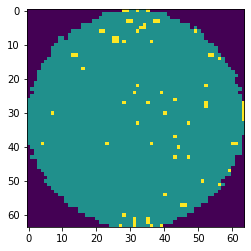

In [64]:
plt.imshow(train_x[5].astype(np.int32))

In [65]:
val_split = 0.2
num_val = math.floor(len(train_y)*val_split)
indice = np.arange(train_x.shape[0])
np.random.shuffle(indice)
train_x = train_x[indice]/255
train_y = train_y[indice]
partial_train_x = train_x[:-num_val]
val_x = train_x[-num_val:]
partial_train_y = train_y[:-num_val]
val_y = train_y[-num_val:]
print(partial_train_x.shape,partial_train_y.shape)
print(val_x.shape,val_y.shape)

(43484, 64, 64, 1) (43484, 9)
(10871, 64, 64, 1) (10871, 9)


In [66]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    return lr

In [67]:
def Bottleneck(in_planes, planes, expansion, x, stride = 1):
    residual = x
    x = layers.Conv2D(planes, (1, 1), strides = 1, padding = "same", use_bias=False)(x)
    x = layers.BatchNormalization(trainable = False)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(planes, (3, 3), strides = stride, padding = "same", use_bias=False)(x)
    x = layers.BatchNormalization(trainable = False)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(expansion*planes, (3, 3), strides = 1, padding = "same", use_bias=False)(x)
    x = layers.BatchNormalization(trainable = False)(x)
    
    if stride != 1 or in_planes != expansion*planes:
        residual = layers.Conv2D(expansion*planes, (1, 1), strides = stride, padding = "same", use_bias=False)(residual)
        residual = layers.BatchNormalization(trainable = False)(residual)

    x = layers.add([x, residual])
    x = layers.Activation('relu')(x)
    return x

In [68]:
def build_model():
    inputs = keras.Input(shape=(64, 64, 1))
    x = layers.Conv2D(filters=32, kernel_size=3, padding="same", use_bias=False)(inputs)

    x = Bottleneck(32, 16, 4, x)
    x = Bottleneck(64, 16, 4, x)

    x = Bottleneck(64, 32, 4, x, 2)
    x = Bottleneck(128, 32, 4, x)
    
    x = Bottleneck(128, 64, 4, x, 2)
    x = Bottleneck(256, 64, 4, x)

    x = Bottleneck(256, 128, 4, x, 2)
    x = Bottleneck(512, 128, 4, x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(9, activation="softmax")(x)

    return keras.Model(inputs=inputs, outputs=outputs)

In [69]:
model = build_model()
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['acc'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_104 (Conv2D)             (None, 64, 64, 32)   288         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_105 (Conv2D)             (None, 64, 64, 16)   512         conv2d_104[0][0]                 
__________________________________________________________________________________________________
batch_normalization_100 (BatchN (None, 64, 64, 16)   64          conv2d_105[0][0]                 
____________________________________________________________________________________________

In [70]:
history = model.fit(
      partial_train_x,partial_train_y,
      batch_size=128,
      validation_data=(val_x,val_y),
      epochs=100,
      #verbose = 0
      )

Epoch 1/100
340/340 [==============================] - 25s 70ms/step - loss: 0.8718 - acc: 0.7537 - val_loss: 0.4735 - val_acc: 0.8629
Epoch 2/100
340/340 [==============================] - 23s 69ms/step - loss: 0.4244 - acc: 0.8753 - val_loss: 0.4013 - val_acc: 0.8795
Epoch 3/100
340/340 [==============================] - 23s 69ms/step - loss: 0.3841 - acc: 0.8885 - val_loss: 0.3813 - val_acc: 0.8879
Epoch 4/100
340/340 [==============================] - 23s 69ms/step - loss: 0.3590 - acc: 0.8976 - val_loss: 0.3533 - val_acc: 0.8972
Epoch 5/100
340/340 [==============================] - 24s 69ms/step - loss: 0.3227 - acc: 0.9055 - val_loss: 0.2781 - val_acc: 0.9122
Epoch 6/100
340/340 [==============================] - 24s 69ms/step - loss: 0.2402 - acc: 0.9228 - val_loss: 0.2097 - val_acc: 0.9342
Epoch 7/100
340/340 [==============================] - 24s 69ms/step - loss: 0.1829 - acc: 0.9411 - val_loss: 0.1778 - val_acc: 0.9438
Epoch 8/100
340/340 [==============================] - 

KeyboardInterrupt: 

In [71]:
val_y_preds = model.predict(val_x)
error = np.zeros(9)
for i,pred in enumerate(val_y_preds):
    if val_y[i, np.argmax(pred)] == 0:
        error[np.argmax(val_y[i])] += 1
print(error)


[ 8. 12. 36. 10. 54.  5. 47.  1. 18.]
